<a href="https://colab.research.google.com/github/sachinkun21/HuggingFace_lessons/blob/main/Chapter_2_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Text Classification:
Text classification is one of the most common tasks in NLP; it can be used for a broad range of applications, such as tagging customer feedback into categories or routing support tickets according to their language. Chances are that your email program’s spam filter is using text classification to protect your inbox from a deluge of unwanted junk!

A common type of text classification is sentiment analysis, which aims to identify the polarity of a given text.

In this notebook, we’ll tackle this task using a variant of BERT called DistilBERT.1 The main advantage of this model is that it achieves comparable performance to BERT, while being significantly smaller and more efficient. This enables us to train a classifier in a few minutes, and if you want to train a larger BERT model you can simply change the checkpoint of the pretrained model. A checkpoint corresponds to the set of weights that are loaded into a given transformer architecture.

This will also be our first encounter with three of the core libraries from the Hugging Face ecosystem: nlpt_pin01 Datasets, nlpt_pin01 Tokenizers, and nlpt_pin01 Transformers. As shown in Figure 2-2, these libraries will allow us to quickly go from raw text to a fine-tuned model that can be used for inference on new tweets. So, in the spirit of Optimus Prime, let’s dive in, “transform, and roll out!"

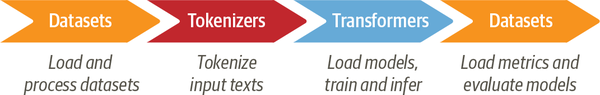

A typical pipeline for training transformer models with the Datasets, Tokenizers, and Transformers libraries in English Twitter messages. Unlike most sentiment analysis datasets that involve just “positive” and “negative” polarities, this dataset contains six basic emotions: anger, disgust, fear, joy, sadness, and surprise. Given a tweet, our task will be to train a model that can classify it into one of these emotions.

Let's start by installing necessary packages:

In [1]:
!pip install transformers
!pip install datasets
!pip install umap-learn

### The Dataset:


To build our emotion detector we’ll use a great dataset from an article that explored how emotions are represented

We will use Datasets to download the data from the Hugging Face Hub. The Datasets is based on Apache Arrow, which defines a typed columnar format that is more memory efficient than native Python. We can use the list_datasets() function to see what datasets are available on the Hub

In [2]:
from datasets import list_datasets

print(len(list_datasets()))
print(list_datasets()[:5])

4450
['assin', 'ar_res_reviews', 'ambig_qa', 'bianet', 'ag_news']


We see that each dataset is given a name, so let’s load the emotion dataset with the load_dataset() function:

In [3]:
from datasets import load_dataset

emotions = load_dataset('emotion')

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
print(emotions)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


Let's access a few Examples:

In [5]:
train_ds = emotions['train']
print(train_ds[0:5])
print(train_ds.features)

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}
{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


We can convert our dataset object to a pandas DataFrame. To enable the conversion, Datasets provides a set_format() method that allows us to change the output format of the Dataset

In [6]:
# set format to pandas
import pandas as pd

emotions.set_format('pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


As you can see, the column headers have been preserved and the first few rows match our previous views of the data. However, the labels are represented as integers, so let’s use the int2str() method of the label feature to create a new column in our DataFrame with the corresponding label names:

In [7]:
# apply labels

def label_int2str(int_label):
  return emotions["train"].features['label'].int2str(int_label)

df['label_name'] = df['label'].map(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


#### What If My Dataset Is Not on the Hub?
We can also load the datasets locally by using the csv script and pointing the data_files argument to the train.txt file:

      emotions_local = load_dataset("csv", data_files="train.txt", sep=";", names=["text", "label"])

## EDA: 
Before diving into building a classifier, let’s take a closer look at the dataset and perform some EDA

#### Looking at the Class Distribution:

Let's analyze the class distribution and check if our data is balanced

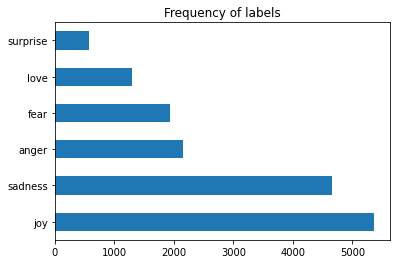

In [8]:
# Class distribution
import matplotlib.pyplot as plt

df["label_name"].value_counts().plot(kind = 'barh')
plt.title("Frequency of labels")
plt.show()

fromm the plot above, the data looks quite imbalanced with most data points belonging to joy while least belonging to surprise.

In such cases, instead of accuracy as our evaluation metric we should choose for f1-score or any other metric which doesn't favor majority class

#### Length of tweets: 
Transformer models have a maximum input sequence length that is referred to as the maximum context size. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text.

Let's have a an estimate of length of our tweets in order to decide the size of context:


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


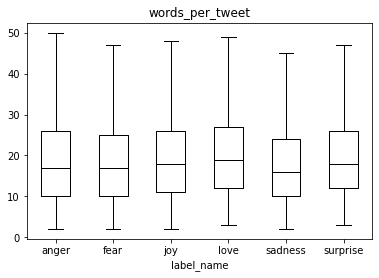

In [9]:
df["words_per_tweet"] = df['text'].map(lambda x : len(x.split(" ")))
df.boxplot("words_per_tweet", by = "label_name", grid = False, showfliers = False, color = 'black')
plt.suptitle("")
plt.show()

From the boxplot, we see that for each emotion, most tweets are around 15 words long and the longest tweets are well below DistilBERT’s maximum context size. 

Texts that are longer than a model’s context size need to be truncated, which can lead to a loss in performance if the truncated text contains crucial information; in this case, it looks like that won’t be an issue.

As we know that ML models can process numerical data only, Let’s now figure out how we can convert these raw texts into a format suitable for Transformers! 
Also we can reset the output format of our dataset since we don’t need the DataFrame format anymore:

In [10]:
emotions.reset_format()

## Tokenization:
Transformer models like DistilBERT cannot receive raw strings as input; instead, they assume the text has been tokenized and encoded as numerical vectors. Tokenization is the step of breaking down a string into the atomic units used in the model. There are several tokenization strategies one can adopt, and the optimal splitting of words into subunits is usually learned from the corpus.

In [11]:
# tokenization
from transformers import AutoTokenizer

model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

sample_text = "Hi my name is Sachin Kaushik"

encoded_text = tokenizer(sample_text)
print("Encoded Text: ", encoded_text)

Encoded Text:  {'input_ids': [101, 7632, 2026, 2171, 2003, 17266, 10606, 10556, 20668, 5480, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [12]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'hi', 'my', 'name', 'is', 'sac', '##hin', 'ka', '##ush', '##ik', '[SEP]']


In [13]:
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)
print(tokenizer.model_input_names)

30522
512
['input_ids', 'attention_mask']


### Tokenizing the whole dataset:
To tokenize the whole corpus, we’ll use the map() method of our DatasetDict object. We’ll encounter this method many times throughout this book, as it provides a convenient way to apply a processing function to each element in a dataset. As we’ll soon see, the map() method can also be used to create new rows and columns.

To get started, the first thing we need is a processing function to tokenize our examples with:

In [14]:
def tokenize_batch(batch):
  return tokenizer(batch['text'], padding = True, truncation = True)

print(tokenize_batch(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


This function applies the tokenizer to a batch of examples; padding=True will pad the examples with zeros to the size of the longest one in a batch, and truncation=True will truncate the examples to the model’s maximum context size. To see tokenize() in action, we passed a batch of two examples from the training set.



- Once we’ve defined a processing function, we can apply it across all the splits in the corpus in a single line of code:


In [15]:
emotions_encoded = emotions.map(tokenize_batch, batched=True, batch_size=None)

Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-68ca8d31fbc22dee.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-40cc0b5b1c95792f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-edf5d37acfb0bcc0.arrow


By default, the map() method operates individually on every example in the corpus, so setting batched=True will encode the tweets in batches. Because we’ve set batch_size=None our tokenize() function will be applied on the full dataset as a single batch. This ensures that the input tensors and attention masks have the same shape globally, and we can see that this operation has added new input_ids and attention_mask columns to the dataset:

In [16]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## Training a text classifier:






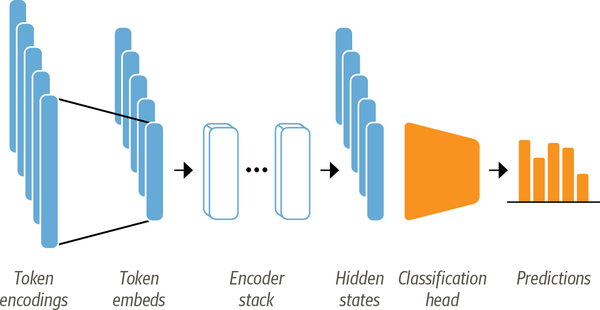

The architecture used for sequence classification with an encoder-based transformer; it consists of the model’s pretrained body combined with a custom classification head.

We have two options to train such a model on our Twitter dataset:

1. Feature extraction

      We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.

2. Fine-tuning

      We train the whole model end-to-end, which also updates the parameters of the pretrained model.

In the following sections we explore both options for DistilBERT and examine their trade-offs.

## Transformers as Feature Extractors:
Using a transformer as a feature extractor is fairly simple. As shown in Figure 2-5, we freeze the body’s weights during training and use the hidden states as features for the classifier. The advantage of this approach is that we can quickly train a small or shallow model. Such a model could be a neural classification layer or a method that does not rely on gradients, such as a random forest. This method is especially convenient if GPUs are unavailable Using a transformer as a feature extractor is fairly simple. As shown in Figure 2-5, we freeze the body’s weights during training and use the hidden states as features for the classifier. The advantage of this approach is that we can quickly train a small or shallow model. Such a model could be a neural classification layer or a method that does not rely on gradients, such as a random forest. This method is especially convenient if GPUs are unavailable, since the hidden states only need to be precomputed once.
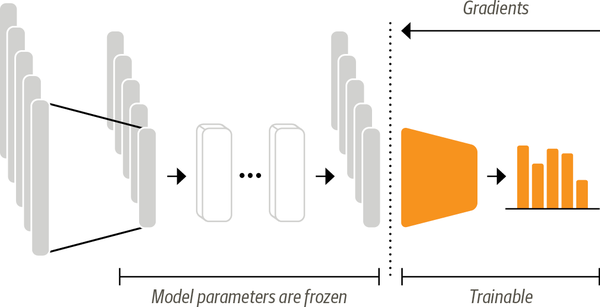

#### Using pretrained models

We will use another convenient auto class from Huggingface Transformers called AutoModel. Similar to the AutoTokenizer class, AutoModel has a from_pretrained() method to load the weights of a pretrained model. Let’s use this method to load the DistilBERT checkpoint:


In [17]:
from transformers import AutoModel
import torch 

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Here we’ve used PyTorch to check whether a GPU is available or not, and then chained the PyTorch nn.Module.to() method to the model loader. This ensures that the model will run on the GPU if we have one. If not, the model will run on the CPU, which can be considerably slower.

The AutoModel class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states. Let’s take a look at how we can extract these states from our corpus.

#### Extracting the last hidden states

To warm up, let’s retrieve the last hidden states for a single string. The first thing we need to do is encode the string and convert the tokens to PyTorch tensors. This can be done by providing the return_tensors="pt" argument to the tokenizer as follows:

In [18]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


As we can see, the resulting tensor has the shape [batch_size, n_tokens]. Now that we have the encodings as a tensor, the final step is to place them on the same device as the model and pass the inputs as follows:


In [19]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


Here we’ve used the torch.no_grad() context manager to disable the automatic calculation of the gradient. This is useful for inference since it reduces the memory footprint of the computations. Depending on the model configuration, the output can contain several objects, such as the hidden states, losses, or attentions, arranged in a class similar to a namedtuple in Python. In our example, the model output is an instance of BaseModelOutput, and we can simply access its attributes by name. The current model returns only one attribute, which is the last hidden state, so let’s examine its shape:

In [20]:
outputs.last_hidden_state.shape

torch.Size([1, 6, 768])

Looking at the hidden state tensor, we see that it has the shape [batch_size, n_tokens, hidden_dim]. In other words, a 768-dimensional vector is returned for each of the 6 input tokens. For classification tasks, it is common practice to just use the hidden state associated with the [CLS] token as the input feature. Since this token appears at the start of each sequence, we can extract it by simply indexing into outputs.last_hidden_state as follows:

Now we know how to get the last hidden state for a single string; let’s do the same for the whole dataset by creating a new hidden_state column that stores all these vectors. As we did with the tokenizer, we’ll use the map() method of DatasetDict to extract all the hidden states in one go. The first thing we need to do is wrap the previous steps in a processing function:

In [21]:
def get_hidden_states(batch):
  # Place model inputs on the GPU/CPU
  inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
  
  # Extract last hidden states
  with torch.no_grad():
    output = model(**inputs).last_hidden_state
  
  # Return vector for [CLS] token
  return {"hidden_state": output[:,0].cpu().numpy()}

text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
get_hidden_states(inputs)['hidden_state'].shape

(1, 768)

Since The map() method requires the processing function to return Python or NumPy objects when we’re using batched inputs we converted the hidden_state to numpy array on CPU.

Also our model expects tensors as inputs, the next thing to do is convert the input_ids and attention_mask columns to the "torch" format, as follows:

In [22]:
emotions_encoded.set_format("torch", columns = ["input_ids", "attention_mask", "label"])

We can then go ahead and extract the hidden states across all splits in one go:

In [ ]:
emotions_encoded = emotions_encoded.map(get_hidden_states, batched = True)

  0%|          | 0/16 [00:00<?, ?ba/s]

As we did not set batch_size=None in this case, the default batch_size=1000 is used instead. As expected, applying the extract_​hid⁠den_​states() function has added a new hidden_state column to our dataset:

In [ ]:
emotions_encoded['train'].column_names


#### Creating a feature matrix

The preprocessed dataset now contains all the information we need to train a classifier on it. We will use the hidden states as input features and the labels as targets. We can easily create the corresponding arrays in the well-known Scikit-learn format as follows:




In [ ]:
import numpy as np

X_train = np.array(emotions_encoded["train"]["hidden_state"])
X_valid = np.array(emotions_encoded["validation"]["hidden_state"])
y_train = np.array(emotions_encoded["train"]["label"])
y_valid = np.array(emotions_encoded["validation"]["label"])
print(X_train.shape, X_valid.shape)

Before we train a model on the hidden states, it’s good practice to perform a quick check to ensure that they provide a useful representation of the emotions we want to classify. In the next section, we’ll see how visualizing the features provides a fast way to achieve this.

We will reduce the dimension of hidden_state to 2D using UMAP Library and plot them:

In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

The result is an array with the same number of training samples, but with only 2 features instead of the 768 we started with! Let’s investigate the compressed data a little bit further and plot the density of points for each category separately:

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

From this plot we can see some clear patterns: the negative feelings such as sadness, anger, and fear all occupy similar regions with slightly varying distributions. On the other hand, joy and love are well separated from the negative emotions and also share a similar space. Finally, surprise is scattered all over the place. Although we may have hoped for some separation, this is in no way guaranteed since the model was not trained to know the difference between these emotions. It only learned them implicitly by guessing the masked words in texts.

Now that we’ve gained some insight into the features of our dataset, let’s finally train a model on it!

We’ve seen that the hidden states are somewhat different between the emotions, although for several of them there is no obvious boundary. Let’s use these hidden states to train a logistic regression model with Scikit-learn. Training such a simple model is fast and does not require a GPU:


In [ ]:
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

Looking at the accuracy, it might appear that our model is just a bit better than random—but since we are dealing with an unbalanced multiclass dataset, it’s actually significantly better. 

 We can further investigate the performance of the model by looking at the confusion matrix of the classifier, which tells us the relationship between the true and predicted labels:



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

We can see that anger and fear are most often confused with sadness, which agrees with the observation we made when visualizing the embeddings. Also, love and surprise are frequently mistaken for joy.

In the next section we will explore the fine-tuning approach, which leads to superior classification performance. It is, however, important to note that doing this requires more computational resources, such as GPUs, that might not be available in your organization. In cases like these, a feature-based approach can be a good compromise between doing traditional machine learning and deep learning.


## Fine-Tuning Transformers

Let’s now explore the process if fine-tuning a transformer end-to-end. With the fine-tuning approach we do not use the hidden states as fixed features, but instead train them as shown in Figure below. 

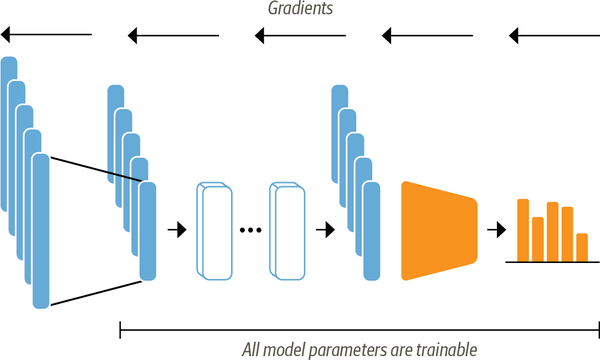

This requires the classification head to be differentiable, which is why this method usually uses a neural network for classification.

Training the hidden states that serve as inputs to the classification model will help us avoid the problem of working with data that may not be well suited for the classification task. Instead, the initial hidden states adapt during training to decrease the model loss and thus increase its performance.

We’ll be using the Trainer API from huggingface Transformers to simplify the training loop. Let’s look at the ingredients we need to set one up!


#### Loading a pretrained model

The first thing we need is a pretrained DistilBERT model like the one we used in the feature-based approach. The only slight modification is that we use the AutoModelForSequenceClassification model instead of AutoModel. The difference is that the AutoModelForSequenceClassification model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model. We just need to specify how many labels the model has to predict (six in our case), since this dictates the number of outputs the classification head has:

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model_ckpt = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = num_labels).to(device)

Next step is to define the metrics that we’ll use to evaluate our model’s performance during fine-tuning.
Defining the performance metrics

To monitor metrics during training, we need to define a compute_metrics() function for the Trainer. This function receives an EvalPrediction object (which is a named tuple with predictions and label_ids attributes) and needs to return a dictionary that maps each metric’s name to its value. For our application, we’ll compute the F1-score and the accuracy of the model as follows:

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}


Now our dataset as well as metruc is ready. One last thing we will need is Hyperparameters used for training. So let's define that next:

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"])//batch_size
model_name = f"{model_ckpt}-finetuned-emotion_classification"
training_args = TrainingArguments(output_dir = model_name,
                                  num_train_epochs = 2,
                                  learning_rate = 2e-5, 
                                  per_device_train_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy = "epoch",
                                  disable_tqdm = False,
                                  logging_steps = logging_steps,
                                  log_level = "error"
                                  )

Here we also set the batch size, learning rate, and number of epochs, and specify to load the best model at the end of the training run. With this final ingredient, we can instantiate and fine-tune our model with the Trainer API:

In [ ]:
from transformers import Trainer

trainer = Trainer(model = model, args =  training_args,
                  compute_metrics = compute_metrics,
                  train_dataset = emotions_encoded["train"],
                  eval_dataset = emotions_encoded["validation"],
                  tokenizer = tokenizer
                  )


trainer.train()

looking at the training logs, we can see a significant improvement over the feature-based approach!

We can take a more detailed look at the training metrics by calculating the confusion matrix. To visualize the confusion matrix, we first need to get the predictions on the validation set. The predict() method of the Trainer class returns several useful objects we can use for evaluation:

In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])
print(preds_output)

The output of the predict() method is a PredictionOutput object that contains arrays of predictions and label_ids, along with the metrics we passed to the trainer. For example, the metrics on the validation set can be accessed as follows:

In [ ]:
preds_output.metrics

It also contains the raw predictions for each class. We can decode the predictions greedily using np.argmax(). This yields the predicted labels and has the same format as the labels returned by the Scikit-learn models in the feature-based approach/ We can plot confusion_matrix of prediction as:



In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

plot_confusion_matrix(y_preds, y_valid, label)

This is much closer to the ideal diagonal confusion matrix. The love category is still often confused with joy, which seems natural. surprise is also frequently mistaken for joy, or confused with fear.. Overall the performance of the model seems quite good, but before we call it a day, let’s dive a little deeper into the types of errors our model is likely to make.

### Error analysis

Before moving on to conclusion, we should investigate our model’s predictions a little bit further. A simple yet powerful technique is to sort the validation samples by the model loss. When we pass the label during the forward pass, the loss is automatically calculated and returned. Here’s a function that returns the loss along with the predicted label:

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass(batch):
  inputs  = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  
  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis = -1)
    loss = cross_entropy(output.logits, batch["label"].to(device), reduction = "none")
      
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),  "predicted_label": pred_label.cpu().numpy()}


and map the forward_pass function to emotions dataset:

In [ ]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass, batched=True, batch_size=16)

Finally we con convert our dataset to a dataframe:

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

Let’s sort the dataset wrt Loss and have a look at the data samples with the highest losses:

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

We can clearly see that the model predicted some of the labels incorrectly. On the other hand, it seems that there are quite a few examples with no clear class, which might be either mislabeled or require a new class altogether. In particular, joy seems to be mislabeled several times. With this information we can refine the dataset, which often can lead to as big a performance gain (or more) as having more data or larger models!

When looking at the samples with the lowest losses, we observe that the model seems to be most confident when predicting the sadness class. Deep learning models are exceptionally good at finding and exploiting shortcuts to get to a prediction. For this reason, it is also worth investing time into looking at the examples that the model is most confident about, so that we can be confident that the model does not improperly exploit certain features of the text. So, let’s also look at the predictions with the smallest loss

In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

We now know that the joy is sometimes mislabeled and that the model is most confident about predicting the label sadness. With this information we can make targeted improvements to our dataset, and also keep an eye on the class the model seems to be very confident about.

The last step before serving the trained model is to save it for later usage.  Transformers allows us to do this in a few steps, which we’ll be exploring next